In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.8 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=84df818dd35214b3d049719b936958ee116de2d269aa4544f822e0ecf4a340de
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(64, 64))
    return img


In [ ]:
import pickle
with open('/content/drive/MyDrive/ASDRP/Experiments/Unbalanced Race/sampled_unbalanced_tensors.pickle', 'rb') as handle:
  images = pickle.load(handle)

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/Unbalanced Race/official_unbalanced.csv')

In [ ]:
a['gender'].value_counts()

0    3546
1    2954
Name: gender, dtype: int64

In [ ]:
a['race'].value_counts()

0    6175
1     325
Name: race, dtype: int64

In [ ]:
images = np.array(images)

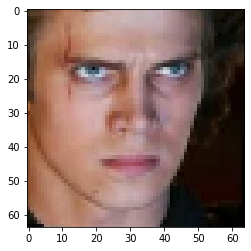

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(b[1000], interpolation='nearest')
plt.show()

In [5]:
import sys
import h5py
class TrainingDatasetLoader(object):
    def __init__(self, data_path):

        print ("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, 'r')

        print ("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache['images'][:]
        self.labels = self.cache['labels'][:].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces:
            selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else:
            selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
            selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
            selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds,:,:,::-1]).astype(np.float32)
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return (self.images[most_prob_inds,...]).astype(np.float32)

    def get_all_train_faces(self):
        return self.images[ self.pos_train_inds ]


In [ ]:
loader.labels[50]

0.0

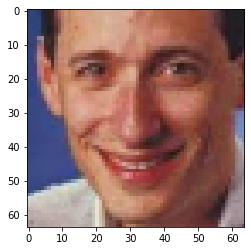

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(loader.images[50], interpolation='nearest')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
y_gender = [i for i in a['gender']]
y_race = [i for i in a['race']]
y_gender = np.array(y_gender)
y_stack = np.vstack((y_gender,y_race))
X, X_test, Y, y_test = train_test_split(images, y_stack[0], test_size=0.2, random_state = 42)
X_alias, X_alias2, Y_alias, y_alias2 = train_test_split(images, y_stack[1], test_size=0.2, random_state = 42)

In [ ]:
Y = np.reshape(Y, (len(Y),1))


In [ ]:
y_test = np.reshape(y_test, (len(y_test),1))

In [ ]:
y_alias2 = np.reshape(y_alias2, (len(y_alias2),1))

In [ ]:
import h5py

h5f = h5py.File('/content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5', 'w')
h5f.create_dataset('images', data=X)
h5f.create_dataset('labels', data=Y)
h5f.create_dataset('test_images', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('test_race', data=y_alias2)

h5f.close()

In [6]:
loader = TrainingDatasetLoader('/content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5')

Opening /content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5
Loading data into memory...


In [ ]:
h5f = h5py.File('/content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5','r')
b = h5f['images'][:]

In [ ]:
loader.labels.shape

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [10]:
### Define the CNN model ###
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras.models import Sequential, Model

input_shape = (64, 64, 3)
'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  inputs = Input((input_shape))
  # convolutional layers
  conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
  maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
  conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
  maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
  conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
  maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
  conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
  maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

  flatten = Flatten() (maxp_4)

  # fully connected layers
  dense_1 = Dense(256, activation='relu') (flatten)
  #dense_2 = Dense(256, activation='relu') (flatten)
  #dense_3 = Dense(256, activation='relu') (flatten)

  dropout_1 = Dropout(0.3) (dense_1)
  #dropout_2 = Dropout(0.3) (dense_2)
  #dropout_3 = Dropout(0.3) (dense_3)

  output_1 = Dense(n_outputs, activation='sigmoid', name='gender_out') (dropout_1)
  #output_2 = Dense(1, activation='softmax', name='race_out') (dropout_2)
  #output_3 = Dense(1, activation='relu', name='age_out') (dropout_3)

  model = Model(inputs=[inputs], outputs=[output_1])

  model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
  
  return model
standard_classifier = make_standard_classifier()

In [11]:
history = standard_classifier.fit(x=images_reduced, y=Y, batch_size=32, epochs=50, validation_data=(val_images, Y_val))

NameError: ignored

In [ ]:
race_dict = {'Light Males':0, 'Light Females':0, 'Dark Males':0, 'Dark Females':0}
for i in range(len(a)):
  if a.iloc[i]['gender'] == 0 and a.iloc[i]['race'] == 0:
    race_dict['Light Males'] += 1
  elif a.iloc[i]['gender'] == 1 and a.iloc[i]['race'] == 0:
    race_dict['Light Females'] += 1
  elif a.iloc[i]['gender'] == 0 and a.iloc[i]['race'] == 1:
    race_dict['Dark Males'] += 1
  else:
    race_dict['Dark Females'] += 1

  

 

In [ ]:
a.iloc[5000]

image     drive/My Drive/ASDRP/Data/UTKFace/50_0_0_20170...
gender                                                    0
race                                                      0
Name: 5000, dtype: object

Text(0, 0.5, 'Number of examples in dataset')

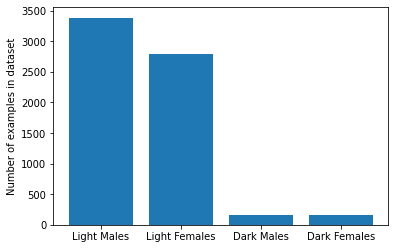

In [ ]:
names = list(race_dict.keys())
values = list(race_dict.values())

plt.bar(range(len(race_dict)), values, tick_label=names)

plt.ylabel("Number of examples in dataset")

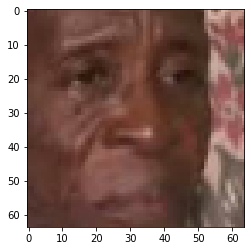

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(images[5000], interpolation='nearest')
plt.show()

In [ ]:
loader.images.shape

(5200, 64, 64, 3)

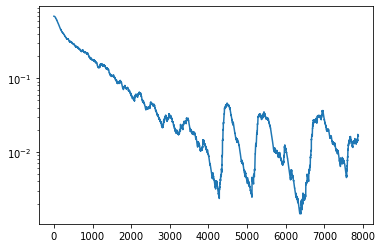

100%|██████████| 162/162 [00:00<00:00, 194.15it/s]


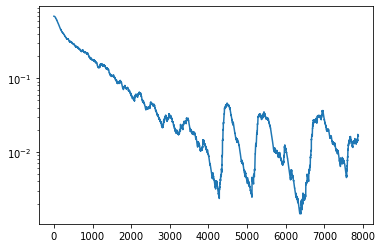

In [ ]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 50  # keep small to run faster
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss

    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
  
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(1300)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9900


In [ ]:
from sklearn.metrics import confusion_matrix
import keras

race_total = {'Light Male':0, 'Light Female':0, 'Dark Male': 0, 'Dark Female': 0}
race_correct = {'Light Male':0, 'Light Female':0, 'Dark Male': 0, 'Dark Female': 0}
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
test_acc_metric = keras.metrics.BinaryAccuracy()
list2 = []
predictions = []

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(1)
for step, (x_batch_test, y_batch_test) in enumerate(test_dataset):
  if y_test[step] == 1 and y_alias2[step] == 1:
      race_total['Dark Female'] += 1
  elif y_test[step] == 1 and y_alias2[step] == 0:
      race_total['Light Female'] += 1
  elif y_test[step] == 0 and y_alias2[step] == 1:
      race_total['Dark Male'] += 1
  else:
      race_total['Light Male'] += 1
  with tf.GradientTape() as tape:
    logits = standard_classifier(x_batch_test, training=False)
    if logits >= 0.5:
      predictions.append(1)
    else:
      predictions.append(0)
    loss_value = loss_fn(y_batch_test,logits)
    test_acc_metric.update_state(y_batch_test, logits)
    list2.append(test_acc_metric.result().numpy())
  if step >= 1:
    if list2[step] >= list2[step-1]:
      if y_test[step] == 1 and y_alias2[step] == 1:
        race_correct['Dark Female'] += 1
      elif y_test[step] == 1 and y_alias2[step] == 0:
        race_correct['Light Female'] += 1
      elif y_test[step] == 0 and y_alias2[step] == 1:
        race_correct['Dark Male'] += 1
      else:
        race_correct['Light Male'] += 1

  if step % 100 == 0:
            print(
                "Testing loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1)))

test_acc = test_acc_metric.result()
print("Testing acc %.4f" % (float(test_acc),))


Testing loss (for one batch) at step 0: 16.5341
Seen so far: 1 samples
Testing loss (for one batch) at step 100: 0.0000
Seen so far: 101 samples
Testing loss (for one batch) at step 200: 0.6033
Seen so far: 201 samples
Testing loss (for one batch) at step 300: 0.0000
Seen so far: 301 samples
Testing loss (for one batch) at step 400: 0.0000
Seen so far: 401 samples
Testing loss (for one batch) at step 500: 0.0242
Seen so far: 501 samples
Testing loss (for one batch) at step 600: 21.0478
Seen so far: 601 samples
Testing loss (for one batch) at step 700: 7.3684
Seen so far: 701 samples
Testing loss (for one batch) at step 800: 0.0003
Seen so far: 801 samples
Testing loss (for one batch) at step 900: 0.0000
Seen so far: 901 samples
Testing loss (for one batch) at step 1000: 0.0000
Seen so far: 1001 samples
Testing loss (for one batch) at step 1100: 9.4743
Seen so far: 1101 samples
Testing loss (for one batch) at step 1200: 0.0001
Seen so far: 1201 samples
Testing acc 0.5000


In [ ]:
y_alias2[0][0]

0

In [ ]:
race_total

{'Dark Female': 184, 'Dark Male': 179, 'Light Female': 432, 'Light Male': 505}

In [ ]:
race_correct

{'Dark Female': 144, 'Dark Male': 151, 'Light Female': 313, 'Light Male': 437}

In [ ]:
for i in race_total:
  print(f'Percentage of {i} class in testing dataset: {round(race_total[i]/sum(race_total.values()), 2) * 100} %')
  print(f'Testing accuracy of {i} class: {round(float(race_correct[i] / race_total[i]),3) * 100} %')

Percentage of Light Male class in testing dataset: 39.0 %
Testing accuracy of Light Male class: 86.5 %
Percentage of Light Female class in testing dataset: 33.0 %
Testing accuracy of Light Female class: 72.5 %
Percentage of Dark Male class in testing dataset: 14.000000000000002 %
Testing accuracy of Dark Male class: 84.39999999999999 %
Percentage of Dark Female class in testing dataset: 14.000000000000002 %
Testing accuracy of Dark Female class: 78.3 %


In [ ]:
print(loader.labels.shape)

(5200, 1)


In [ ]:
labels = loader.labels.reshape((6500,1))

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO
  
  return vae_loss

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 100/100
Recomputing the sampling probabilities


  0%|          | 0/162 [00:00<?, ?it/s]

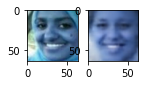

100%|██████████| 162/162 [00:01<00:00, 133.12it/s]


In [ ]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 100  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = debiasing_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

In [ ]:
from sklearn.metrics import confusion_matrix
import keras


race_total = {'Light Male':0, 'Light Female':0, 'Dark Male': 0, 'Dark Female': 0}
race_correct = {'Light Male':0, 'Light Female':0, 'Dark Male': 0, 'Dark Female': 0}
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
test_acc_metric = keras.metrics.BinaryAccuracy()
list2 = []
predictions = []

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(1)
for step, (x_batch_test, y_batch_test) in enumerate(test_dataset):
  if y_test[step] == 1 and y_alias2[step] == 1:
      race_total['Dark Female'] += 1
  elif y_test[step] == 1 and y_alias2[step] == 0:
      race_total['Light Female'] += 1
  elif y_test[step] == 0 and y_alias2[step] == 1:
      race_total['Dark Male'] += 1
  else:
      race_total['Light Male'] += 1
  with tf.GradientTape() as tape:
    logits = dbvae.predict(np.array(x_batch_test, dtype=np.float32))
    dbvae_probs = tf.sigmoid(logits)
    if dbvae_probs >= 0.5:
      predictions.append(1)
    else:
      predictions.append(0)
    loss_value = loss_fn(y_batch_test,dbvae_probs)
    test_acc_metric.update_state(y_batch_test, dbvae_probs)
    list2.append(test_acc_metric.result().numpy())
  if step >= 1:
    if list2[step] >= list2[step-1]:
      if y_test[step] == 1 and y_alias2[step] == 1:
        race_correct['Dark Female'] += 1
      elif y_test[step] == 1 and y_alias2[step] == 0:
        race_correct['Light Female'] += 1
      elif y_test[step] == 0 and y_alias2[step] == 1:
        race_correct['Dark Male'] += 1
      else:
        race_correct['Light Male'] += 1

  if step % 100 == 0:
            print(
                "Testing loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1)))

test_acc = test_acc_metric.result()
print("Testing acc %.4f" % (float(test_acc),))


tf.Tensor([[-14.684141]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1952546e-07]], shape=(1, 1), dtype=float32)
Testing loss (for one batch) at step 0: 0.6931
Seen so far: 1 samples
tf.Tensor([[17.493086]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[-25.376135]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.534209e-12]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.318662]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982009]], shape=(1, 1), dtype=float32)
tf.Tensor([[-7.6251593]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00048778]], shape=(1, 1), dtype=float32)
tf.Tensor([[-11.621786]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.968473e-06]], shape=(1, 1), dtype=float32)
tf.Tensor([[-12.103871]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.5380015e-06]], shape=(1, 1), dtype=float32)
tf.Tensor([[18.843735]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.19735986]], shape=(1, 1), dtype=float32)
tf.Ten

In [ ]:
race_total

{'Dark Female': 184, 'Dark Male': 179, 'Light Female': 432, 'Light Male': 505}

In [ ]:
race_correct

{'Dark Female': 148, 'Dark Male': 149, 'Light Female': 326, 'Light Male': 445}

In [ ]:
for i in race_total:
  print(f'Percentage of {i} class in testing dataset: {round(race_total[i]/sum(race_total.values()), 2) * 100} %')
  print(f'Testing accuracy of {i} class: {round(float(race_correct[i] / race_total[i]),3) * 100} %')

Percentage of Light Male class in testing dataset: 39.0 %
Testing accuracy of Light Male class: 88.1 %
Percentage of Light Female class in testing dataset: 33.0 %
Testing accuracy of Light Female class: 75.5 %
Percentage of Dark Male class in testing dataset: 14.000000000000002 %
Testing accuracy of Dark Male class: 83.2 %
Percentage of Dark Female class in testing dataset: 14.000000000000002 %
Testing accuracy of Dark Female class: 80.4 %
